In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import rosen
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_all_points(x, y):
    result = []
    for row_x in x:
        val_x = row_x[0]
        for row_y in y:
            val_y = row_y[0]
            result.append([val_x, val_y])
    return torch.tensor(result)

def get_2D_array_column(array, column: int):
    result = []
    for row in array:
        val = row[column]
        result.append([val])
    return torch.tensor(result)

In [3]:
def calculate_target_function(train_X, dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    result = []
    for point in train_X:  # each row is a point
        val = rosen(point)
        result.append([val])

    return torch.tensor(result)


In [4]:
def BO_procedure(train_X, train_Y, bounds):
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    UCB = UpperConfidenceBound(gp, beta=10, dtype=torch.float32)  # higher beta means more exploration (example: 10000)

    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20, dtype=torch.float32
    )

    candidate_z = calculate_target_function(candidate)
    print(f'    Candidate: ({candidate[0][0].numpy()}, {candidate[0][1].numpy()}, {candidate_z[0][0].numpy()})')

    new_X = torch.cat([train_X, candidate])
    new_Y = torch.cat([train_Y, candidate_z])

    return gp, new_X, new_Y

In [5]:
def plot(model, train_X, train_Y, bounds):
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    %matplotlib inline

    target_x = torch.linspace(bounds[0][0], bounds[1][0], 31).unsqueeze(1)
    target_y = torch.linspace(bounds[0][1], bounds[1][1], 31).unsqueeze(1)
    target_xy = get_all_points(target_x, target_y)
    target_z = calculate_target_function(target_xy)

    # # Initialize plot
    ax = plt.subplot(111, projection='3d')

    # # no need for gradients
    with torch.no_grad():

        # plot target function (inclusion of noise decreases accuracy)
        ax.scatter(get_2D_array_column(target_xy, 0), get_2D_array_column(target_xy, 1), target_z, color='#F2CA19', alpha=0.2)
        # X, Y = np.meshgrid(get_2D_array_column(target_xy, 0), get_2D_array_column(target_xy, 1))
        # ax.plot_surface(X, Y, target_z)

        # compute posterior
        posterior = model.posterior(target_xy)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax.scatter(get_2D_array_column(train_X, 0), get_2D_array_column(train_X, 1), train_Y, color='k')
        # Plot posterior means as blue line
        ax.scatter(get_2D_array_column(target_xy, 0), get_2D_array_column(target_xy, 1), posterior.mean.cpu().numpy(), color='#0057E9')
        # Shade between the lower and upper confidence bounds
        ax.scatter(get_2D_array_column(target_xy, 0), get_2D_array_column(target_xy, 1), upper.cpu().numpy(), alpha=0.25, color='#87E911')
        ax.scatter(get_2D_array_column(target_xy, 0), get_2D_array_column(target_xy, 1), lower.cpu().numpy(), alpha=0.25, color='#FF00BD')

    ax.legend(['Target Function', 'Observed Data', 'Mean', 'Upper Confidence', 'Lower Confidence'])
    plt.tight_layout()

Iteration 1:
    Candidate: (-0.4584946036338806, -1.0, 148.58978271484375)
Iteration 2:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 3:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 4:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 5:
    Candidate: (-0.6499420404434204, 0.7701270580291748, 14.812005996704102)
Iteration 6:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 7:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 8:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 9:
    Candidate: (-1.0, -1.0, 404.0)
Iteration 10:
    Candidate: (-1.0, -1.0, 404.0)


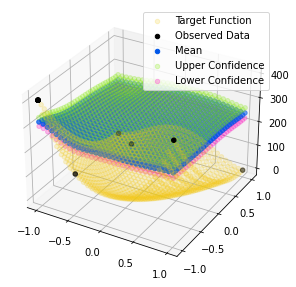

In [6]:
# use a GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = dtype=torch.float32
NUM_ITERATIONS = 10
BOUNDS = torch.tensor([[-1.0, -1.0], [1.0, 1.0]])

x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 2, dtype=DTYPE, device=DEVICE).unsqueeze(1)
y = torch.linspace(BOUNDS[0][1], BOUNDS[1][1], 2, dtype=DTYPE, device=DEVICE).unsqueeze(1)
train_XY = get_all_points(x, y)
train_Z = calculate_target_function(train_XY)

for i in range(NUM_ITERATIONS):
    print(f'Iteration {i + 1}:')
    model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)

plot(model, train_XY, train_Z, BOUNDS)